## LOG: Most recent changes: 
- Switched the webscraping part to see if there is a BA affiliated with a given ROI and if so, it now skips ahead to scraping Wikipedia without doing a google search (should decrease run-time significantly and yield better results too). Can be switched to be an option if people prefer to not prioritize BA (let me know) - CSS 4/14/2021

In [ ]:
!pip install nltools

In [ ]:
import numpy as np
import pandas as pd
import ast
from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
import matplotlib.pyplot as plt
import collections

In [ ]:
#upload the files from the folder that I shared and then you can jump to the first section
from google.colab import files
uploaded = files.upload()

Saving shen_dictionary.csv to shen_dictionary (3).csv
Saving xilin_268parc_labeldict.txt to xilin_268parc_labeldict (3).txt
Saving xilin_268parc_labels.csv to xilin_268parc_labels (3).csv


In [ ]:
#alternative to grabbing the folders
#!wget https://drive.google.com/drive/u/1/folders/1hjecTpwTqLnLSMa50h8zw_LhgFp33po_

--2021-04-14 19:39:33--  https://drive.google.com/drive/u/1/folders/1hjecTpwTqLnLSMa50h8zw_LhgFp33po_
Resolving drive.google.com (drive.google.com)... 74.125.195.102, 74.125.195.113, 74.125.195.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/drive/folders/1hjecTpwTqLnLSMa50h8zw_LhgFp33po_ [following]
--2021-04-14 19:39:33--  https://drive.google.com/drive/folders/1hjecTpwTqLnLSMa50h8zw_LhgFp33po_
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘1hjecTpwTqLnLSMa50h8zw_LhgFp33po_’

1hjecTpwTqLnLSMa50h     [  <=>               ] 234.64K   624KB/s    in 0.4s    

2021-04-14 19:39:33 (624 KB/s) - ‘1hjecTpwTqLnLSMa50h8zw_LhgFp33po_’ saved [240271]



In [ ]:
import io
shen_dictionary = pd.read_csv(io.BytesIO(uploaded['shen_dictionary.csv']))
labels = pd.read_csv('xilin_268parc_labels.csv')

In [ ]:
list_temp = ['gui_Lobes','gui_BrodLabels','gui_Networks']
roi_breakdown = {}
for n in list_temp:
    roi_breakdown[n] = []

In [ ]:
roi_breakdown['gui_Lobes'] = {
1: 'R-Prefrontal',
2: 'R-MotorStrip',  3: 'R-Insula',
4: 'R-Parietal',    5: 'R-Temporal',
6: 'R-Occipital',   7: 'R-Limbic',
8: 'R-Cerebellum',  9: 'R-Subcortical',
10: 'R-Brainstem', 11: 'L-Prefrontal',
12: 'L-MotorStrip',13: 'L-Insula',
14: 'L-Parietal',  15: 'L-Temporal',
16: 'L-Occipital', 17: 'L-Limbic',
18: 'L-Cerebellum',19: 'L-Subcortical',
20: 'L-Brainstem' };

roi_breakdown['gui_BrodLabels'] = {1 : 'PrimSensory (1)',   4 : 'PrimMotor (4)',
5 : 'SensoryAssoc (5)',  6 : 'BA6',
7 : 'BA7',              8 : 'BA8',
9 : 'BA9',              10 : 'BA10',
11 : 'BA11',            13 : 'Insula (13)',
14 : 'BA14',            17 : 'PrimVisual (17)',
18 : 'VisualAssoc (18)', 19 : 'BA19',
20 : 'BA20',            21 : 'BA21',
22 : 'BA22',            23 : 'BA23',
24 : 'BA24',            25 : 'BA25',
30 : 'BA30',            31 : 'BA31',
32 : 'BA32',            34 : 'BA34',
36 : 'Parahip (36)',     37 : 'Fusiform (37)',
38 : 'BA38',            39 : 'BA39',
40 : 'BA40',            41 : 'PrimAuditory (41)',
44 : 'BA44',            45 : 'BA45',
46 : 'BA46',            47 : 'BA47',
48 : 'Caudate (48)',     49 : 'Putamen (49)',
50 : 'Thalamus (50)',    51 : 'GlobPal (51)',
52 : 'NucAccumb (52)',   53 : 'Amygdala (53)',
54 : 'Hippocampus (54)', 55 : 'Hypothalamus (55)',
58 : 'BrainStem',        57 : 'Cerebellum',
    };

roi_breakdown['gui_Networks'] ={
1:  'Somato-Motor',
3:  'Cingular-opercular',
4:  'Auditory',
5:  'Default Mode',
7:  'Visual',
8:  'Frontal-Parietal',
9:  'Salience',
10: 'Subcortical',
11: 'Ventral-Attention',
12: 'Dorsal-Attention'
};

## Determing the information about ROI of choice: 
- note that all of these values *should be* 1 indexed, not 0 indexed (like your code might be) because that is how the information is presented in the files that you imported 
- In case you make a mistake, do not worry: this is fixed for you automatically and you will see a warning below
- Note: **right now, the expected input [next cell] is just numbers separated by a space ex: 0 28 145 or separated by commas. Let me know what other input types would be better and I can add exceptions**
- A dateframe is created

In [ ]:
roi_l = input("Type ROI number: ")
roi_l = roi_l.replace(',', '') #if you do include a comma, it handles it- added 4/11
roi_l = roi_l.split()

Type ROI number: 0, 1, 129, 128, 130, 132, 133, 135, 258, 137, 138, 260, 140, 263, 264, 265, 16, 17, 266, 267, 22, 23, 24, 150


In [ ]:
if '0' in roi_l:
  print('warning! make sure this is in python indexing (index starts from 0). input yes if you would like to convert your index')
  roi_l = [int(x) + 1 for x in roi_l]
  roi_l = [str(x) for x in roi_l] #putting it back into a string
  print('New list!: ',roi_l)
else:
  yn = input('Do you want to fix your index?')
  if yn == 'yes':
    roi_l = [int(x) + 1 for x in roi_l]
    roi_l = [str(x) for x in roi_l] #putting it back into a string
    print('New list!: ',roi_l)

warning! not indexing correctly - needs to start at 0 so fixing this for you automically:
New list!:  ['1', '2', '130', '129', '131', '133', '134', '136', '259', '138', '139', '261', '141', '264', '265', '266', '17', '18', '267', '268', '23', '24', '25', '151']


In [ ]:
lobe_list = []
network_list = []
cols = ['ROI', 'Lobe', 'Network', 'BrodLabel', 'Name']
lst = []
for roi in roi_l:
    row = np.where(labels['Node_No']==int(roi))[0][0]

    Lobe = labels.iloc[row][4]
    Network = labels.iloc[row][6]
    BrodLabel = labels.iloc[row][7]

    try:
        a = roi_breakdown['gui_Lobes'][Lobe]
    except:
        a = Lobe
    try:
        b = roi_breakdown['gui_BrodLabels'][BrodLabel]
    except: 
        b = BrodLabel
    try:
        c = roi_breakdown['gui_Networks'][Network]
    except:
        c = Network
    res = ast.literal_eval(shen_dictionary[roi][0])
    #print('Roi: ', roi, 'Lobe: ',a, 'Network: ', c, 'BrodLabel: ',b, 'Name: ',res['name'])
    lobe_list.append(a)
    network_list.append(c)

    lst.append([roi, a, c, b, res['name']])
df1 = pd.DataFrame(lst, columns=cols)
df1
      

,ROI,Lobe,Network,BrodLabel,Name
0,1,R-Prefrontal,Default Mode,BA11,92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex
1,2,R-Prefrontal,13,BA11,60.56% Subcallosal_Cortex; 38.73% Frontal_Orbi...
2,130,R-Brainstem,13,BrainStem,99.10% Brain-Stem
3,129,R-Brainstem,13,BrainStem,100.00% Brain-Stem
4,131,R-Brainstem,13,BrainStem,100.00% Brain-Stem
5,133,R-Brainstem,13,BrainStem,100.00% Brain-Stem
6,134,L-Prefrontal,Default Mode,BA11,60.87% Subcallosal_Cortex; 15.60% Cingulate_Gy...
7,136,L-Prefrontal,13,BA11,87.07% Subcallosal_Cortex; 10.65% Frontal_Orbi...
8,259,L-Subcortical,Subcortical,Caudate (48),20.66% Subcallosal_Cortex; 19.95% Left_Putamen...
9,138,L-Prefrontal,Default Mode,BA10,45.63% Paracingulate_Gyrus; 30.02% Frontal_Med...


In [ ]:
df1.loc[df1['Network']=='Default Mode']

,ROI,Lobe,Network,BrodLabel,Name
0,1,R-Prefrontal,Default Mode,BA11,92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex
6,134,L-Prefrontal,Default Mode,BA11,60.87% Subcallosal_Cortex; 15.60% Cingulate_Gy...
9,138,L-Prefrontal,Default Mode,BA10,45.63% Paracingulate_Gyrus; 30.02% Frontal_Med...
10,139,L-Prefrontal,Default Mode,BA10,100.00% Frontal_Pole
12,141,L-Prefrontal,Default Mode,BA10,100.00% Frontal_Pole
23,151,L-Prefrontal,Default Mode,BA47,51.03% Frontal_Orbital_Cortex; 25.77% Inferior...
29,42,R-Parietal,Default Mode,BA7,80.25% Precuneous_Cortex; 11.39% Cuneal_Cortex...
32,185,L-Temporal,Default Mode,BA38,86.53% Temporal_Pole; 7.16% Temporal_Fusiform_...
33,186,L-Temporal,Default Mode,BA38,96.42% Temporal_Pole


# Plot ROIs: 
Note: for now, I colored each ROI that you input as the same color. However, we could potentially color them based on which network they're in. I figured that the DMN may be the most interesting network for us so I just colored it differently (2 cells down), but it would be VERY easy to put a new color for every network (let me know if this is of interest)

In [ ]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)   

## If you are interested in just seeing where your ROIs are: 

Enter your title here: temp


/usr/local/lib/python3.7/dist-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


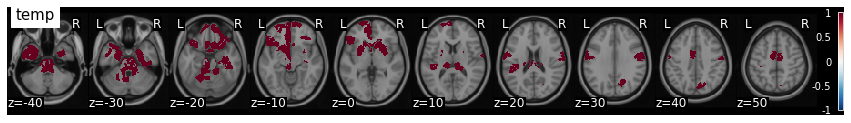

In [ ]:
title_here = input("Enter your title here: ",)
plt_here = []
roi_l_temp = [int(x) - 1 for x in roi_l]
roi_l_temp = [str(x) for x in roi_l_temp]
for n in range(268):
  if str(n) in roi_l_temp:
    plt_here.append(1)
  else:
    plt_here.append(np.nan)
event_value_to_plot = pd.Series(plt_here)
evt_plt = roi_to_brain(event_value_to_plot,mask_x)
evt_plt.plot(symmetric_cbar = True, colorbar=True,cmap='RdBu_r',title=title_here) 


###  If you are interested in labeling the ROIs by network identity:

Enter your title here: temp
What kind of plot do you want? glass or axial?both
Not sure what view you want so printing both


/usr/local/lib/python3.7/dist-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


Plotting unthresholded image


,network,val
0,13.0,-4
1,Auditory,8
2,Cingular-opercular,-12
3,Default Mode,16
4,Somato-Motor,-20
5,Subcortical,24


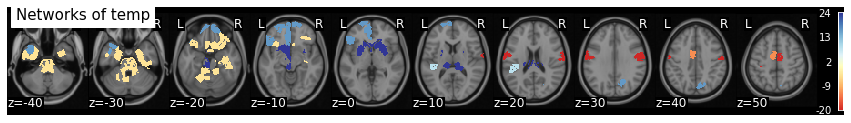

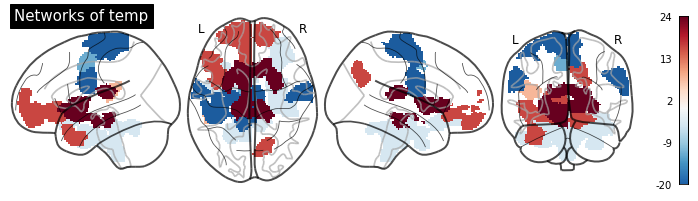

In [ ]:
#### defining a key for your networks in case you want to color code by them (printing key below too)
net = list(np.unique(list((df1['Network']))))
lent=len(np.unique(list(df1['Network'])))
lst = [x for x in range(1, lent**3) if x % 4 == 0][:lent]
for i in range(0, len(lst), 2):
  lst[i]=lst[i]*-1 #switching signs to improve visualization
d={'network':net,'val':lst}
df2 = pd.DataFrame(data=d)

title_here = "Networks of " + input("Enter your title here: ",)
plt_here = []
roi_l_temp = [int(x) - 1 for x in roi_l]
roi_l_temp = [str(x) for x in roi_l_temp]
for n in range(268):
  n_temp = str(n+1)
  if n_temp in roi_l:
    loc_here = pd.DataFrame(df1.loc[df1['ROI'] == n_temp]['Network']).values[0][0]
    if loc_here==13.0:
      loc_here=str(loc_here)
    plt_here.append(df2.loc[df2['network']==loc_here]['val'].values[0])

  else:
    plt_here.append(np.nan)
   
event_value_to_plot = pd.Series(plt_here)
evt_plt = roi_to_brain(event_value_to_plot,mask_x)

kind = input("What kind of plot do you want? glass or axial?" ).lower()
try: 
  evt_plt.plot(view=kind,symmetric_cbar = False, colorbar=True,title=title_here)
except: 
  print('Not sure what view you want so printing both')
  evt_plt.plot(view='axial',symmetric_cbar = False, colorbar=True,cmap='RdYlBu',title=title_here)
  evt_plt.plot(view='glass',symmetric_cbar = False, colorbar=True,title=title_here)
#from nilearn.plotting import plot_glass_brain
#plot_glass_brain(evt_plt.to_nifti(),symmetric_cbar = True,cmap='RdYlBu')
df2

In [ ]:
#if you want an interactive plot
evt_plt.iplot(symmetric_cbar = False, colorbar=True,cmap='RdYlBu',title=title_here) 


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

# Plot distribution of ROIs per Network or Lobe

Note: for networks you will be asked which region you want to expand i.e. pop out of the pie chart. If you do not choose one of the options listed, then it will just create a normal pie chart for you :) 

In [ ]:
def convert(list):
    return tuple(i for i in list)

Which network do you want to explode? ['Default Mode', 13.0, 'Subcortical', 'Somato-Motor']


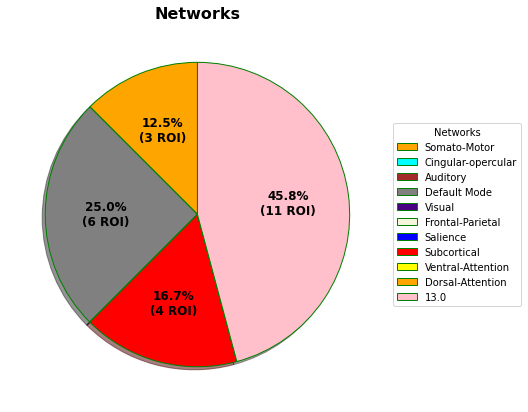

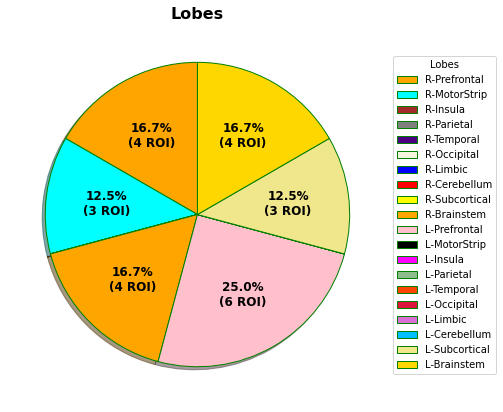

In [ ]:
  
# Creating dataset
net_here = []
for x in roi_breakdown['gui_Networks']:
    net_here.append(roi_breakdown['gui_Networks'][x])
net_here.append(13.0)
ctr = collections.Counter(network_list)

list_temp = list(ctr.keys())
data = []
for ii in range(len(net_here)): 
    if net_here[ii] in list_temp: 
      data.append(ctr[net_here[ii]])
    else:
      data.append(0)
# Creating explode data - can customize here
interest = input("Which network do you want to explode? %s" %list_temp,)
explode = [0.0]*len(net_here)
try: 
    explode[np.where(np.array(net_here)==interest)[0][0]]=.1
    explode = convert(explode)
except: 
    None

# Creating color parameters
colors = ( "orange", "cyan", "brown","grey", "indigo", "beige","blue","red","yellow","orange","pink",
          "black","magenta") 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" } 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    if absolute == 0:
      a = None
    else:
      a = "{:.1f}%\n({:d} ROI)".format(pct, absolute)
    return a
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data, autopct = lambda pct: func(pct, data),
        explode = explode, shadow = True,colors = colors,startangle = 90,
        wedgeprops = wp,textprops = dict(color ="black"))
# Adding legend
ax.legend(wedges, net_here,
          title ="Networks",
          loc ="center left",
          bbox_to_anchor =(1, 0, 1, 1))
  
plt.setp(autotexts, size = 12, weight ="bold")
ax.set_title("Networks",size = 16, weight ="bold")
  
# show plot
plt.show()

  
# Creating dataset
lobe_here = []
for x in roi_breakdown['gui_Lobes']:
    lobe_here.append(roi_breakdown['gui_Lobes'][x])
ctr = collections.Counter(lobe_list)

list_temp = list(ctr.keys())
data = []
for ii in range(len(lobe_here)): 
    if lobe_here[ii] in list_temp: 
      data.append(ctr[lobe_here[ii]])
    else:
      data.append(0) 
# Creating explode data - can customize here
explode = (0.1, 0.0, 0.2, 0.3, 0.0, 0.0,0.1, 0.0, 0.2, 0.3, 0.0, 0.0,0.0)
  
# Creating color parameters
colors = ( "orange", "cyan", "brown","grey", "indigo", "beige","blue","red","yellow","orange","pink",
          "black","magenta","darkseagreen","orangered","crimson", "orchid", "deepskyblue","khaki","gold",
          "brown","linen","bisque","lime","cornflowerblue")
  
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }
  
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    if absolute == 0:
      a = None
    else:
      a = "{:.1f}%\n({:d} ROI)".format(pct, absolute)
    return a
  
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data, autopct = lambda pct: func(pct, data),
          shadow = True,colors = colors,startangle = 90, wedgeprops = wp,
                                  textprops = dict(color ="black")) 
# Adding legend
ax.legend(wedges, lobe_here,title ="Lobes",loc ="center left",bbox_to_anchor =(1, 0, 1, 1))
  
plt.setp(autotexts, size = 12, weight ="bold")
ax.set_title("Lobes",size = 16, weight ="bold")
  
# show plot
plt.show()

# Function?
- Warning: this relies on webscrapping from Wikipedia pages that have a "function" section, but there is a limit on the number of requests you are allowed to make

- HTTP Error 429: Too Many Requests

In [ ]:
!pip install google-search-results
!pip install wikipedia
import urllib.request
from bs4 import BeautifulSoup
import wikipedia

In [ ]:
sch = []
for i in range(len(df1)):
    # searching by Brodmann area should yield the best results; 
    if len(df1['BrodLabel'][i])==3 or len(df1['BrodLabel'][i])==4: #i.e. if it BAX or BAXX (might be better than the name)
        p = df1['BrodLabel'][i][2:]
        x = 'Brodmann area ' + p
        print('there should be a Wikipedia page for each Brodmann area so skipping ahead!')
        sch.append(x)
    else:
        try:   
            if df1['Name'][i].find(';') > 0:
                p = df1['Name'][i].find(';') #works if multiple options
                x = df1['Name'][i][7:p]
            elif df1['Name'][i][:7]=='100.00%':
                x = df1['Name'][i][8:]
            #print(x)
                #url = 'https://google.com/search?q=Where+can+I+get+the+best+coffee'
            url = 'https://google.com/search?q=%s' %x

            # Perform the request
            request = urllib.request.Request(url)

            # Set a normal User Agent header, otherwise Google will block the request.
            request.add_header('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36')
            raw_response = urllib.request.urlopen(request).read()

            # Read the repsonse as a utf-8 string
            html = raw_response.decode("utf-8")

            # The code to get the html contents here.
            soup = BeautifulSoup(html, 'html.parser')

            # Find all the search result divs
            divs = soup.select("#search div.g")
            for div in divs[0]:
            #for div in divs:
                # Search for a h3 tag
                results = div.select("h3")
                # Check if we have found a result
                if (len(results) >= 1):
                    h3 = results[0]
                    if h3.get_text().find('Wikipedia')>0:          
                        a=h3.get_text()
                        #print(a)
                        if not (a[1].isalpha()): #trying to deal with non-English websites - not working well
                            print((a[1].isalpha()))
                            sch.append(x)
                        else:
                            sch.append(h3.get_text()[0:h3.get_text().find('Wikipedia')-3])
                    elif h3.get_text().find('Radiology Reference Article')>0:
                      a=h3.get_text()
                        #print(a)
                      if not (a[1].isalpha()): #trying to deal with non-English websites - not working well
                          print((a[1].isalpha()))
                          sch.append(x)
                      else:
                          sch.append(h3.get_text()[0:h3.get_text().find('Radiology Reference Article')-3])
                    else:
                        sch.append('None')
        except: 
            sch.append('None')
    #except: 
       # sch.append('None')
        #if not (len(results) >= 1):
            #print('true')
            #sch.append('None')
            # Print the title
            #print(h3.get_text())
      # Specify the title of the Wikipedia page


there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!
there should be a Wikipedia page for each Brodmann area so skipping ahead!


In [ ]:
wiki_list = []
func_list = []
for c in sch:
        # Specify the title of the Wikipedia page
    try:
      wiki = wikipedia.page('%s'%c)
      wiki_list.append(wiki)
      text = wiki.content
      if text.find('Function') >0:
          a= text.find('Function')
          func_list.append(text[a+17:a+1000]) # skipping this Function ==\n\n\n===
      else:
          func_list.append(text[:1000])
    except:
      func_list.append('None Available')


/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
#random stuff to clean the outputs - you can ignore this, if you want! 
for x, func in enumerate(func_list):
    func_list[x] = func.replace("===\n", "")
    func_list[x] = func.replace("\n\n\n===", "")
    func_list[x] = func.replace("\n", "")
    func_list[x] = func.replace("===", "")
    func_list[x] = func.replace("\n\n", "")

In [ ]:
df1['Function'] = ""
df1['Function'] = func_list
df1

,ROI,Lobe,Network,BrodLabel,Name,Function
0,1,R-Prefrontal,Default Mode,BA11,92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex,Brodmann area 11 is one of Brodmann's cytologi...
1,2,R-Prefrontal,13,BA11,60.56% Subcallosal_Cortex; 38.73% Frontal_Orbi...,Brodmann area 11 is one of Brodmann's cytologi...
2,130,R-Brainstem,13,BrainStem,99.10% Brain-Stem,None Available
3,129,R-Brainstem,13,BrainStem,100.00% Brain-Stem,are three main functions of the brainstem:The...
4,131,R-Brainstem,13,BrainStem,100.00% Brain-Stem,are three main functions of the brainstem:The...
5,133,R-Brainstem,13,BrainStem,100.00% Brain-Stem,are three main functions of the brainstem:The...
6,134,L-Prefrontal,Default Mode,BA11,60.87% Subcallosal_Cortex; 15.60% Cingulate_Gy...,Brodmann area 11 is one of Brodmann's cytologi...
7,136,L-Prefrontal,13,BA11,87.07% Subcallosal_Cortex; 10.65% Frontal_Orbi...,Brodmann area 11 is one of Brodmann's cytologi...
8,259,L-Subcortical,Subcortical,Caudate (48),20.66% Subcallosal_Cortex; 19.95% Left_Putamen...,None Available
9,138,L-Prefrontal,Default Mode,BA10,45.63% Paracingulate_Gyrus; 30.02% Frontal_Med...,"ugh this region is extensive in humans, its fu..."


In [ ]:
func_list[0]

"Brodmann area 11 is one of Brodmann's cytologically defined regions of the brain. It is in the orbitofrontal cortex which is above the eye sockets (orbitae). It is involved in decision making and processing rewards, planning, encoding new information into long-term memory, and reasoning.\n== In humans ==\nBrodmann area 11, or BA11, is part of the frontal cortex in the human brain. BA11 is the part of the orbitofrontal cortex that covers the medial portion of the ventral surface of the frontal lobe.\nPrefrontal area 11 of Brodmann-1909 is a subdivision of the frontal lobe in the human defined on the basis of cytoarchitecture. Defined and illustrated in Brodmann-1909, it included the areas subsequently illustrated in Brodmann-10 as prefrontal area 11 and rostral area 12.\nArea 11 is a subdivision of the cytoarchitecturally defined frontal region of cerebral cortex of the human. As illustrated in Brodmann-10, It constitutes most of the orbital gyri, gyrus rectus and the most rostral port